# 2024 Winter Introduction to Deep Learning
### Based on Prof. Oh's Youtube Lecture
https://youtube.com/playlist?list=PLvbUC2Zh5oJvByu9KL82bswYT2IKf0K1M

> Assignment #6


*   Youtube Lecture #23-26
*   Written by Seungeun Lee

## 4. Semantic Segmentation w/ pre-trained EfficientNet-b0 based U-Net
*     Custom dataset: https://www.kaggle.com/datasets/intelecai/car-segmentation
*     Download the dataset and unzip it as always.



### Quick Question. What is Instance segmentation, and how it is different from Semantic Segmentation?
*     Hint: https://ganghee-lee.tistory.com/44

## Instance segmentation 은 같은 class여도 각각의 개체를 box를 이용하여 분류하고, semantic segmentation은 class의 개수 만큼 binary하게 계산하므로 같은 class를 같는 개체가 겹쳐있다면 서로를 구분하기 어렵다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm import tqdm

In [2]:
!pip install -q segmentation-models-pytorch ## installing a special library for segmentation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.4 MB/s eta 0:00:00


In [3]:
from torchsummary import summary
import segmentation_models_pytorch as smp

# 런타임 - 런타임 유형 변경 - T4 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/intro-dl/car_seg

/content/drive/MyDrive/intro-dl/car_seg


In [12]:
!unzip -qq /content/drive/MyDrive/intro-dl/car_seg/archive.zip -d /content/drive/MyDrive/intro-dl/car_seg

In [6]:
ROOT = '/content/drive/MyDrive/intro-dl/car_seg/car-segmentation/'
IMAGE_PATH = os.path.join(ROOT, 'images/')
MASK_PATH = os.path.join(ROOT, 'masks/')

In [7]:
import os
print(len(os.listdir(IMAGE_PATH))) ## # of images
assert len(os.listdir(IMAGE_PATH)) == len(os.listdir(MASK_PATH)) # check of the # of images and # of masks are the same
# If not, assertion error comes out, and remaining shells & commands will not be executed

211


In [8]:
n_classes = 5 ## there are 5 classes - check the Kaggle website (background, car, wheel, light, and windows)

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  211


In [9]:
# Spliting data
X_train, X_val = train_test_split(df['id'][:100].values, train_size=0.8, random_state=19) # For now, let's just use 100 images

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))

Train Size   :  80
Val Size     :  20


Image Size (750, 1000, 3)
Mask Size (750, 1000)


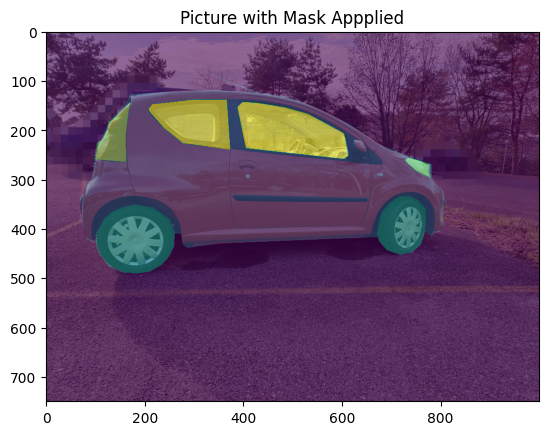

In [10]:
img = Image.open(IMAGE_PATH + df['id'][50] + '.png')
mask = Image.open(MASK_PATH + df['id'][50] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied') ## Randomly choose one sample
plt.show()

In [11]:
class CarDataset(Dataset):

    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self): # 데이터의 길이를 적어주는 부분
        return len(self.X)

    def __getitem__(self, idx): # 데이터에서 특정한 이미지와 마스크 한 쌍을 가져오는 함수
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768)
        img_patches = img_patches.permute(1,0,2,3)

        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        return img_patches, mask_patches

In [12]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()]) # 이미지의 크기를 256,256으로 바꿔주고 빈 공간을 설정한 보간법을 이용하여 보간해줌, 또한 랜덤으로 수직 또는 수평으로 이미지를 뒤집어줌
                                      # 이미지에 가우시안 노이주를 줌, 랜덤으로 밝기를 바꿔줌
t_val = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)]) # 이미지의 크기를 256,256으로 바꿔주고 빈 공간을 설정한 보간법을 이용하여 보간해줌

#datasets
train_set = CarDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = CarDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [13]:
model = smp.Unet('efficientnet-b0', encoder_weights='imagenet', classes=5, activation=None, encoder_depth=5)
# efficientnet 이라는 모델을 바탕으로 Unet을 구성함

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 59.7MB/s]


In [14]:
print(model)

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

In [15]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy # pixel accuray 함수를 정의함

In [16]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=5):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class) # mIOU 함수를 정의함

In [17]:
import torch
import torch.nn.functional as F
import numpy as np

def dice(pred_mask, mask, smooth=1e-10, n_classes=5):
    with torch.no_grad():
        pred_mask_softmax = F.softmax(pred_mask, dim=1)
        pred_mask_argmax = torch.argmax(pred_mask_softmax, dim=1)
        pred_mask_flatten = pred_mask_argmax.contiguous().view(-1)
        mask_flatten = mask.contiguous().view(-1)

        dice_per_class = []

        for clas in range(0, n_classes):  # loop per pixel class
            true_class = pred_mask_flatten == clas
            true_label = mask_flatten == clas

            if true_label.long().sum().item() == 0:  # no exist label in this loop
                dice_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                dice = (2 * intersect + smooth) / (true_class.sum().float() + true_label.sum().float() + smooth)
                dice_per_class.append(dice)

        return np.nanmean(dice_per_class) # dice score 함수를 정의함

### Quick Question. What's (1) pixel accuracy, (2) mIOU, and (3) Dice score? Google it and write your own answer.


# 3개 모두 image segmentation 문제에서 평가 지표로 이용되는 값이다.
## 1. Pixel accuracy : pixel accuracy는  (올바르게 분류된 픽셀의 수)/(전체 픽셀의 수) 이다. 이는 Classfication의 정확도와 유사한 형태이다.

## 2. mIOU : mIOU를 설명하기 전에 IOU(Intersection Over Union)에 대해서 알아야 한다. IOU는 예측된 Segmentation 영역과 실제 Segmentation 영역의 교집합과 합집합의 비율이다. 따라서, (Intersection Area)/(Union Area) 로 계산한다. 이때, mIOU는 각 Class별로 IOU를 구한 후 편균을 구하는 것이다.

## 3. Dice score : Dice score는 예측된 Segmentation 영역과 실제 Segmentation 영역 사기의 조화평균이다. 조화평균이란 평균을 구하는 각 요소의 역수의 산술평균을 구한 뒤 그 값을 다시 역수로 변환하는 것이다. 이는 해당 요소가 전체 데이터에서 차지하는 비율을 반영한 평균을 취하고 싶을 때 사용하는 방법이다.

In [18]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_dice = []; val_acc = []
    train_iou = []; train_dice = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        dice_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            dice_score += dice(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            val_dice_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    val_dice_score += dice(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
#                     torch.save(model, 'Unet-Efficient_IoU-{:.3f}-femur1.pt'.format(val_iou_score/len(val_loader)))

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            val_dice.append(val_dice_score/len(val_loader))
            train_dice.append(dice_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train dice:{:.3f}..".format(dice_score/len(train_loader)),
                  "Val dice:{:.3f}..".format(val_dice_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_dice' :train_dice, 'val_dice':val_dice,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [19]:
max_lr = 1e-3
epoch = 30
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)


100%|██████████| 7/7 [00:16<00:00,  2.39s/it]


Loss Decreasing.. inf >> 1.550 
Epoch:1/30.. Train Loss: 1.656.. Val Loss: 1.550.. Train mIoU:0.117.. Val mIoU: 0.140.. Train dice:0.189.. Val dice:0.217.. Train Acc:0.309.. Val Acc:0.371.. Time: 2.67m


100%|██████████| 7/7 [00:09<00:00,  1.38s/it]


Loss Decreasing.. 1.550 >> 1.279 
Epoch:2/30.. Train Loss: 1.446.. Val Loss: 1.279.. Train mIoU:0.168.. Val mIoU: 0.218.. Train dice:0.248.. Val dice:0.298.. Train Acc:0.461.. Val Acc:0.562.. Time: 1.61m


100%|██████████| 7/7 [00:12<00:00,  1.78s/it]


Loss Decreasing.. 1.279 >> 0.870 
Epoch:3/30.. Train Loss: 1.073.. Val Loss: 0.870.. Train mIoU:0.258.. Val mIoU: 0.293.. Train dice:0.331.. Val dice:0.360.. Train Acc:0.683.. Val Acc:0.759.. Time: 1.62m


100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


Loss Decreasing.. 0.870 >> 0.544 
saving model...
Epoch:4/30.. Train Loss: 0.730.. Val Loss: 0.544.. Train mIoU:0.305.. Val mIoU: 0.325.. Train dice:0.361.. Val dice:0.365.. Train Acc:0.814.. Val Acc:0.846.. Time: 1.60m


100%|██████████| 7/7 [00:09<00:00,  1.41s/it]


Loss Decreasing.. 0.544 >> 0.403 
Epoch:5/30.. Train Loss: 0.477.. Val Loss: 0.403.. Train mIoU:0.335.. Val mIoU: 0.411.. Train dice:0.390.. Val dice:0.475.. Train Acc:0.851.. Val Acc:0.870.. Time: 1.65m


100%|██████████| 7/7 [00:09<00:00,  1.35s/it]


Loss Decreasing.. 0.403 >> 0.329 
Epoch:6/30.. Train Loss: 0.349.. Val Loss: 0.329.. Train mIoU:0.529.. Val mIoU: 0.584.. Train dice:0.616.. Val dice:0.670.. Train Acc:0.897.. Val Acc:0.899.. Time: 1.58m


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


Loss Decreasing.. 0.329 >> 0.203 
Epoch:7/30.. Train Loss: 0.240.. Val Loss: 0.203.. Train mIoU:0.635.. Val mIoU: 0.652.. Train dice:0.705.. Val dice:0.715.. Train Acc:0.930.. Val Acc:0.936.. Time: 1.61m


100%|██████████| 7/7 [00:10<00:00,  1.43s/it]


Loss Decreasing.. 0.203 >> 0.170 
Epoch:8/30.. Train Loss: 0.230.. Val Loss: 0.170.. Train mIoU:0.637.. Val mIoU: 0.668.. Train dice:0.705.. Val dice:0.724.. Train Acc:0.929.. Val Acc:0.946.. Time: 1.71m


100%|██████████| 7/7 [00:08<00:00,  1.15s/it]


Loss Decreasing.. 0.170 >> 0.164 
saving model...
Epoch:9/30.. Train Loss: 0.167.. Val Loss: 0.164.. Train mIoU:0.669.. Val mIoU: 0.662.. Train dice:0.726.. Val dice:0.722.. Train Acc:0.947.. Val Acc:0.944.. Time: 1.58m


100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


Loss Decreasing.. 0.164 >> 0.150 
Epoch:10/30.. Train Loss: 0.154.. Val Loss: 0.150.. Train mIoU:0.673.. Val mIoU: 0.684.. Train dice:0.728.. Val dice:0.734.. Train Acc:0.951.. Val Acc:0.953.. Time: 2.15m


100%|██████████| 7/7 [00:08<00:00,  1.16s/it]


Loss Not Decrease for 1 time
Epoch:11/30.. Train Loss: 0.162.. Val Loss: 0.170.. Train mIoU:0.668.. Val mIoU: 0.654.. Train dice:0.723.. Val dice:0.710.. Train Acc:0.947.. Val Acc:0.942.. Time: 1.94m


100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


Loss Decreasing.. 0.170 >> 0.153 
Epoch:12/30.. Train Loss: 0.169.. Val Loss: 0.153.. Train mIoU:0.655.. Val mIoU: 0.675.. Train dice:0.716.. Val dice:0.729.. Train Acc:0.943.. Val Acc:0.949.. Time: 1.96m


100%|██████████| 7/7 [00:09<00:00,  1.41s/it]


Loss Decreasing.. 0.153 >> 0.139 
Epoch:13/30.. Train Loss: 0.143.. Val Loss: 0.139.. Train mIoU:0.673.. Val mIoU: 0.683.. Train dice:0.728.. Val dice:0.735.. Train Acc:0.951.. Val Acc:0.951.. Time: 2.00m


100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


Loss Not Decrease for 2 time
Epoch:14/30.. Train Loss: 0.126.. Val Loss: 0.147.. Train mIoU:0.692.. Val mIoU: 0.692.. Train dice:0.740.. Val dice:0.740.. Train Acc:0.957.. Val Acc:0.951.. Time: 2.11m


100%|██████████| 7/7 [00:13<00:00,  1.90s/it]


Loss Decreasing.. 0.147 >> 0.117 
Epoch:15/30.. Train Loss: 0.115.. Val Loss: 0.117.. Train mIoU:0.699.. Val mIoU: 0.702.. Train dice:0.746.. Val dice:0.747.. Train Acc:0.960.. Val Acc:0.959.. Time: 1.86m


100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


Loss Decreasing.. 0.117 >> 0.111 
saving model...
Epoch:16/30.. Train Loss: 0.106.. Val Loss: 0.111.. Train mIoU:0.704.. Val mIoU: 0.706.. Train dice:0.751.. Val dice:0.750.. Train Acc:0.962.. Val Acc:0.961.. Time: 1.61m


100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


Loss Not Decrease for 3 time
Epoch:17/30.. Train Loss: 0.117.. Val Loss: 0.177.. Train mIoU:0.698.. Val mIoU: 0.630.. Train dice:0.747.. Val dice:0.698.. Train Acc:0.957.. Val Acc:0.938.. Time: 1.80m


100%|██████████| 7/7 [00:13<00:00,  1.91s/it]


Loss Decreasing.. 0.177 >> 0.118 
Epoch:18/30.. Train Loss: 0.107.. Val Loss: 0.118.. Train mIoU:0.702.. Val mIoU: 0.702.. Train dice:0.752.. Val dice:0.748.. Train Acc:0.962.. Val Acc:0.959.. Time: 1.92m


100%|██████████| 7/7 [00:14<00:00,  2.04s/it]


Loss Decreasing.. 0.118 >> 0.106 
Epoch:19/30.. Train Loss: 0.098.. Val Loss: 0.106.. Train mIoU:0.712.. Val mIoU: 0.711.. Train dice:0.759.. Val dice:0.753.. Train Acc:0.965.. Val Acc:0.962.. Time: 2.13m


100%|██████████| 7/7 [00:13<00:00,  1.97s/it]


Loss Not Decrease for 4 time
Epoch:20/30.. Train Loss: 0.093.. Val Loss: 0.107.. Train mIoU:0.716.. Val mIoU: 0.715.. Train dice:0.764.. Val dice:0.765.. Train Acc:0.966.. Val Acc:0.961.. Time: 2.17m


100%|██████████| 7/7 [00:08<00:00,  1.18s/it]


Loss Decreasing.. 0.107 >> 0.101 
Epoch:21/30.. Train Loss: 0.093.. Val Loss: 0.101.. Train mIoU:0.727.. Val mIoU: 0.721.. Train dice:0.782.. Val dice:0.770.. Train Acc:0.966.. Val Acc:0.963.. Time: 1.59m


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


Loss Decreasing.. 0.101 >> 0.098 
Epoch:22/30.. Train Loss: 0.089.. Val Loss: 0.098.. Train mIoU:0.729.. Val mIoU: 0.724.. Train dice:0.782.. Val dice:0.770.. Train Acc:0.968.. Val Acc:0.965.. Time: 1.58m


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


Loss Not Decrease for 5 time
Epoch:23/30.. Train Loss: 0.084.. Val Loss: 0.098.. Train mIoU:0.737.. Val mIoU: 0.721.. Train dice:0.789.. Val dice:0.775.. Train Acc:0.969.. Val Acc:0.965.. Time: 1.63m


100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


Loss Decreasing.. 0.098 >> 0.098 
saving model...
Epoch:24/30.. Train Loss: 0.085.. Val Loss: 0.098.. Train mIoU:0.751.. Val mIoU: 0.735.. Train dice:0.809.. Val dice:0.792.. Train Acc:0.969.. Val Acc:0.964.. Time: 1.62m


100%|██████████| 7/7 [00:09<00:00,  1.39s/it]


Loss Decreasing.. 0.098 >> 0.095 
Epoch:25/30.. Train Loss: 0.085.. Val Loss: 0.095.. Train mIoU:0.759.. Val mIoU: 0.741.. Train dice:0.816.. Val dice:0.797.. Train Acc:0.970.. Val Acc:0.965.. Time: 1.58m


100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


Loss Decreasing.. 0.095 >> 0.095 
Epoch:26/30.. Train Loss: 0.080.. Val Loss: 0.095.. Train mIoU:0.755.. Val mIoU: 0.741.. Train dice:0.811.. Val dice:0.797.. Train Acc:0.971.. Val Acc:0.965.. Time: 1.62m


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Loss Not Decrease for 6 time
Epoch:27/30.. Train Loss: 0.080.. Val Loss: 0.097.. Train mIoU:0.751.. Val mIoU: 0.737.. Train dice:0.807.. Val dice:0.793.. Train Acc:0.971.. Val Acc:0.965.. Time: 1.63m


100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


Loss Decreasing.. 0.097 >> 0.094 
Epoch:28/30.. Train Loss: 0.077.. Val Loss: 0.094.. Train mIoU:0.760.. Val mIoU: 0.742.. Train dice:0.815.. Val dice:0.799.. Train Acc:0.972.. Val Acc:0.966.. Time: 1.61m


100%|██████████| 7/7 [00:09<00:00,  1.37s/it]

Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Total time: 51.79 m


In [20]:
torch.save(model, 'car-segmentation-unet-1.pt')

In [21]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_dice(history):
    plt.plot(history['train_dice'], label='train_dice', marker='*')
    plt.plot(history['val_dice'], label='val_dice',  marker='*')
    plt.title('dice per epoch'); plt.ylabel('dice')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

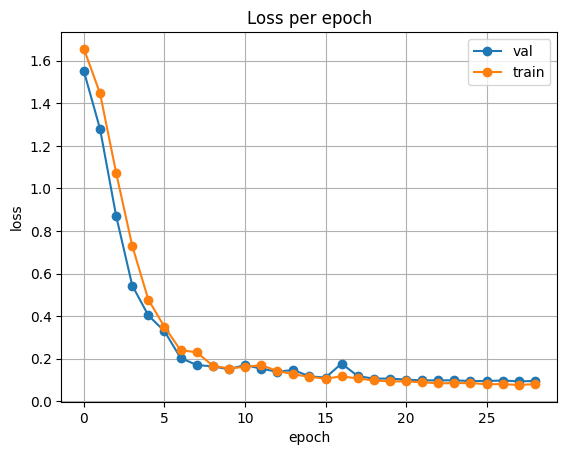

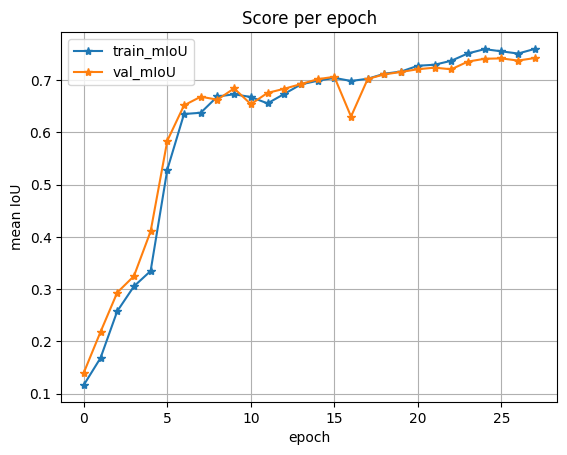

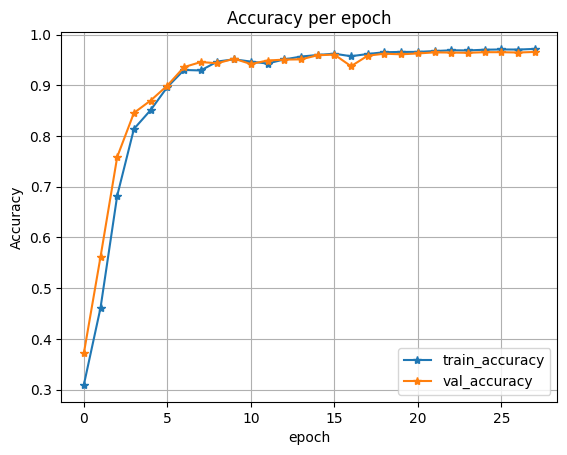

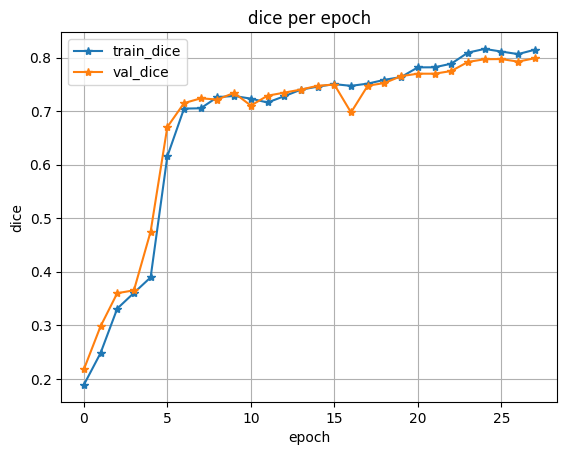

In [22]:
plot_loss(history)
plot_score(history)
plot_acc(history)
plot_dice(history)

In [23]:
class CarDataset(Dataset):

    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        mask = torch.from_numpy(mask).long()

        return img, mask


t_test = A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)
test_set = CarDataset(IMAGE_PATH, MASK_PATH, X_val, transform=t_test)

In [24]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        mask2 = mask.cpu()

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)


    return masked, score

In [25]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [26]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [27]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

mob_miou = miou_score(model, test_set)

100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


In [28]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

mob_acc = pixel_acc(model, test_set)

100%|██████████| 20/20 [00:08<00:00,  2.32it/s]


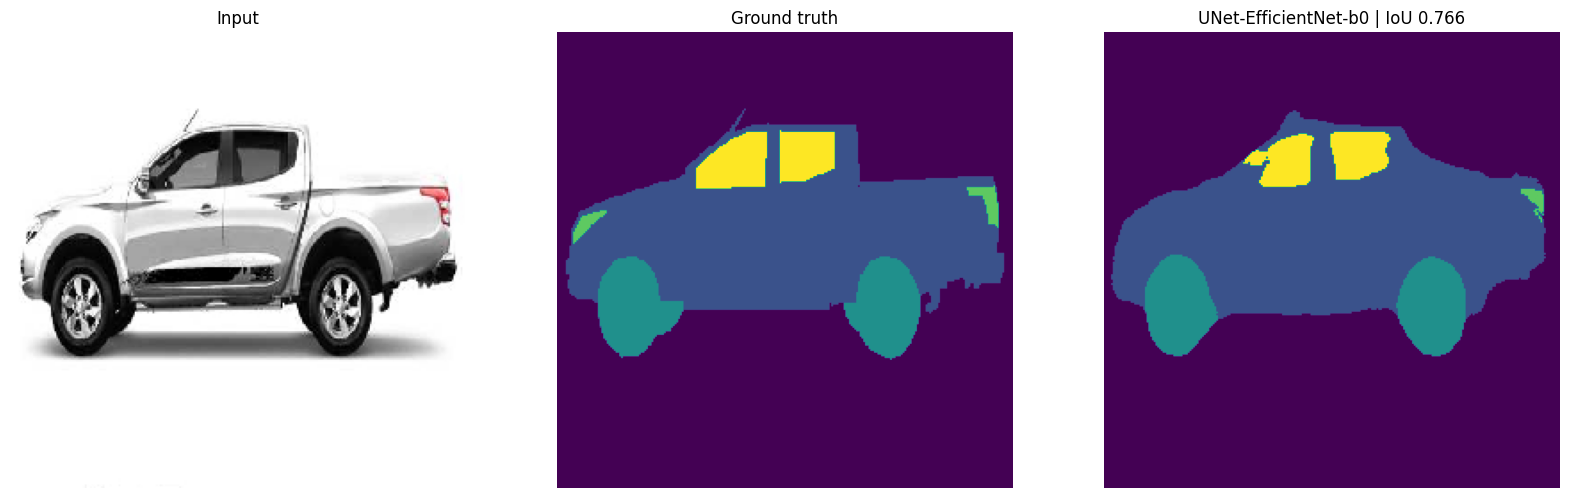

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Input');
ax1.set_axis_off()


ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-EfficientNet-b0 | IoU {:.3f}'.format(score))
ax3.set_axis_off()

### Question 1. Write a brief explanation of the entire code. Just try to get the feel for this file. ChatGPT allowed!

# 1. assignment6-4 코드는 차와 배경이 포함된 사진을 입력받아 background, car, wheel, lights, window 총 5개의 클래스에 대한 image segmentation을 출력하는 코드이다.

# 2. 데이터 같은 경우에는 train 데이터로 80개의 이미를 사용했고, test 데이터로 20개의 이미지를 이용했다.

# 3. 모델로는 Efficient net을 기반으로 한 Unet을 이용했다.

# 4. 또한, 모델의 예측값을 통해 pixel accuray, mIOT, Dice score 총 3가지의 평가지표의 값을 계산하여 출력하여, 각각의 평가 지표에 대한 모델의 성능을 쉽게 알아볼 수 있었다.

### The End.

##### Please upload your Colab file @Github https://github.com/duneag2/intro-dl/tree/main/Assignment6

*   First, make your folder by your name (e.g. seungeun)
*   Then upload your "Jupyter Notebook" file under that directory

###### Need Help?



*   Please refer to this link https://yeko90.tistory.com/entry/%ED%8C%8C%EC%9D%B4%EC%8D%AC-colab%EC%BD%94%EB%9E%A9%EC%97%90%EC%84%9C-%EC%95%95%EC%B6%95%ED%8C%8C%EC%9D%BC-%ED%92%80%EA%B8%B0 OR
*   Just save your Jupyter Notebook (.ipynb) file in here (colab) and upload via 'Add file' - 'Upload files' https://nthree.tistory.com/60